In [1]:
# https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

JUPYTER = True

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

/home/zhuoli/anaconda3/envs/tensorflow/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Using TensorFlow backend.


This following code resizes the images to 64x64 and samples 2000 images (8%) of the data to run efficiently as a Kaggle Kernel. Also separated cats and dogs for exploratory analysis.

Generating the Labels
We're dealing with a binary classification problem here - (1) dog (0) cat. The lables can be created by looping over the file names in the train directory. It's nice to see the training data is perfectly balanced.


In [4]:
TRAIN_DIR = '../input/train/'
TEST_DIR = '../input/test/'

if JUPYTER:
    TRAIN_DIR = '../../../input/dog_cat/train/'
    TEST_DIR = '../../../input/dog_cat/test/'

ROWS = 64
COLS = 64
CHANNELS = 3

TEST_RATIO = 0.1

# Image path array
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

train_images = train_images[:int(len(train_images) * TEST_RATIO)]
train_dogs = train_dogs[:int(len(train_dogs) * TEST_RATIO)]
train_cats = train_cats[:int(len(train_cats) * TEST_RATIO)]
test_images = test_images[:int(len(test_images) * TEST_RATIO)]



# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
train_images = train_dogs[:] + train_cats[:]
random.shuffle(train_images)
test_images =  test_images[:]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 2500
Processed 250 of 2500
Processed 500 of 2500
Processed 750 of 2500
Processed 1000 of 2500
Processed 1250 of 2500
Processed 1500 of 2500
Processed 1750 of 2500
Processed 2000 of 2500
Processed 2250 of 2500
Processed 0 of 1250
Processed 250 of 1250
Processed 500 of 1250
Processed 750 of 1250
Processed 1000 of 1250
Train shape: (2500, 3, 64, 64)
Test shape: (1250, 3, 64, 64)


DOG: 1250
CAT:1250


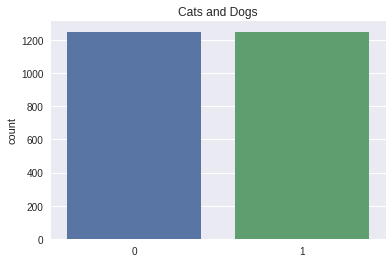

In [5]:
labels = []
dog = 0
cat = 0
for path in train_images:
    if 'dog' in path.split('/')[-1]:
        labels.append(1)
        dog+=1
    else:
        labels.append(0)
        cat+=1

print("DOG: " + str(dog))
print("CAT:" + str(cat))

sns.countplot(labels)
sns.plt.title('Cats and Dogs')

### Checking out Cats and Dogs
A quick side-by-side comparison of the animals.

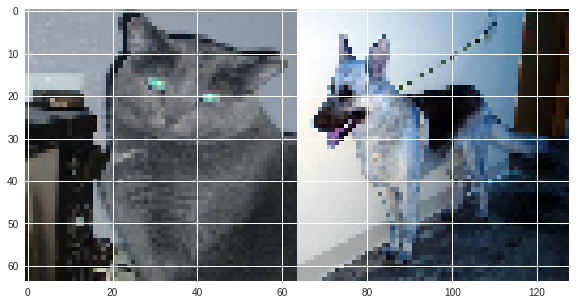

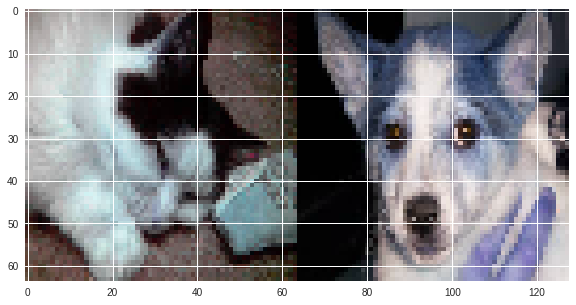

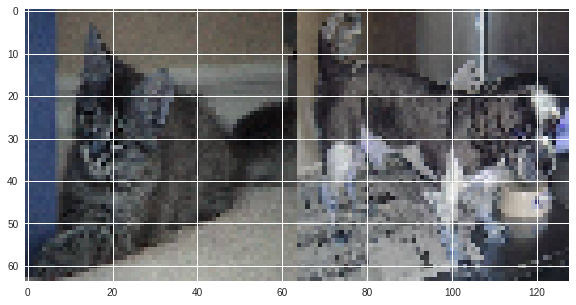

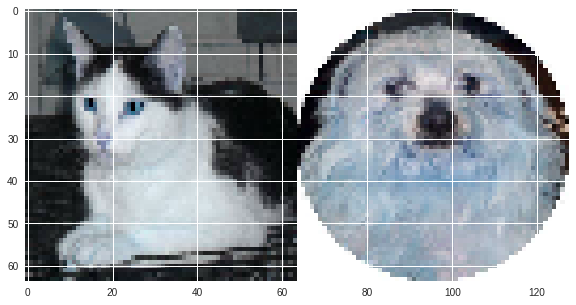

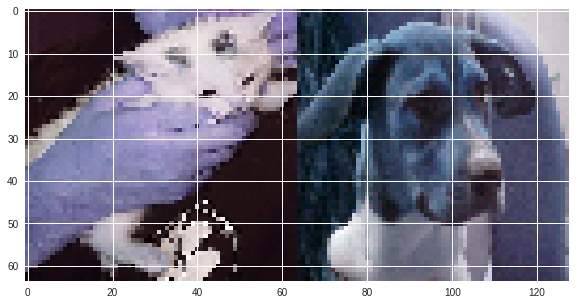

In [6]:
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,5):
    show_cats_and_dogs(idx)

### CatdogNet-16
A scaled down version of the VGG-16, with a few notable changes.
Number of convolution filters cut in half, fully connected (dense) layers scaled down.
Optimizer changed to RMSprop.
Output layer activation set to sigmoid for binary crossentropy.
Some layers commented out for efficiency.
The full network takes about 80s per epoch on a GTX1070 (or 2hr+ on CPU) on the full dataset. (This script only trains on 8% of the 25K images. )

In [5]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def catdog():
    
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
    
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
    
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))

    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = catdog()

### Train and Predict
I'm using Keras's early stopping callback to end training when the validation loss stops improving, otherwise the model will overfit. I will also be tracking the loss history on each epoch to visualize the overfitting trend.
Note: A slice of 1000 images was used to fit the model for CPU efficency. The model's perfrmance improves significantly when used on the entire dataset.
In [8]:


In [6]:
nb_epoch = 10
batch_size = 16

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_catdog():
    
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(test, verbose=0)
    return predictions, history

predictions, history = run_catdog()

Epoch 00006: early stopping


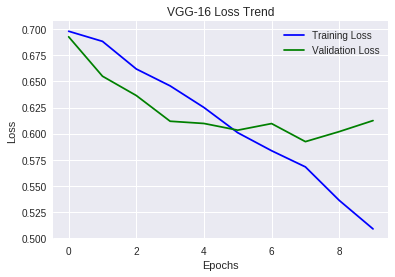

In [14]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

### How'd We Do?
I'm pretty sure I can distinguish a cat from a dog 100% of the time, but how confident is the model?...
Tip: Run on the full dataset with a GPU for a LB logloss of ~0.4 and accuracy at approx 90%.

I am 71.89% sure this is a Cat


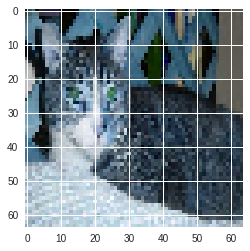

I am 57.94% sure this is a Dog


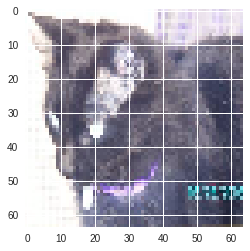

I am 90.33% sure this is a Dog


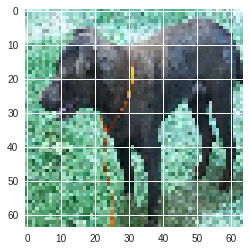

I am 65.03% sure this is a Cat


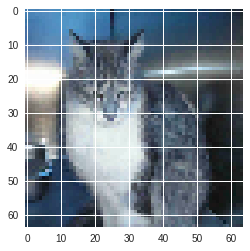

I am 69.73% sure this is a Cat


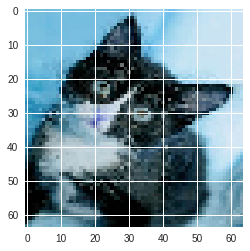

I am 67.82% sure this is a Dog


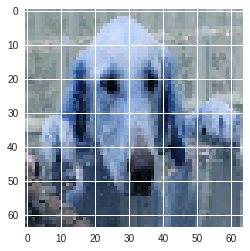

I am 59.01% sure this is a Cat


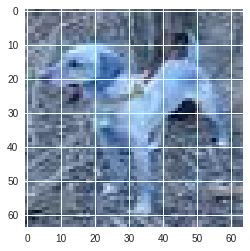

I am 70.37% sure this is a Cat


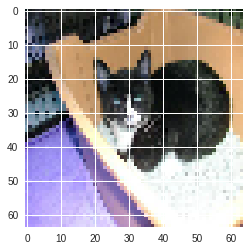

I am 55.31% sure this is a Dog


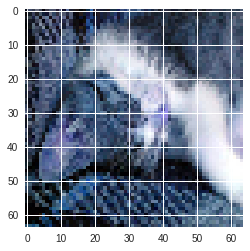

I am 57.68% sure this is a Dog


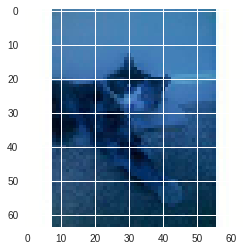

In [7]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()